In [24]:
import csv
import networkx as nx 
import numpy as np
import pandas as pd 
import community 
from itertools import compress
import matplotlib.pyplot as plt 
import seaborn as sns
from seaborn import color_palette, set_style, palplot
plt.style.use('ggplot')
%matplotlib inline

#### Load and clean data 

In [25]:
## read pre-processed data from stata
df = pd.read_stata('../data/0_CPIS_CDIS_BIS_USTIC_merged_fixed1.dta')
keep_var = ['countrycode','counterpart_code','country','counterpart','year','CDIS_IAD','CPIS_IAP','loans_dep']
df = df[keep_var]                           ## keep only used variables 
df = df.replace(np.nan,0)                   ## turn na to zero 
num = df._get_numeric_data()
num[num < 0] = 0                            ## turn negative to zero 
df['total'] = df[['CDIS_IAD','CPIS_IAP','loans_dep']].sum(axis=1)
df.describe()

,countrycode,counterpart_code,year,CDIS_IAD,CPIS_IAP,loans_dep,total
count,102611.000000,102611.000000,102611.000000,1.026110e+05,1.026110e+05,1.026110e+05,1.026110e+05
mean,448.978973,459.162506,2011.827367,2.274913e+03,3.019251e+03,1.636379e+03,6.930741e+03
std,286.647552,296.652344,2.220511,2.192672e+04,3.130591e+04,2.060122e+04,6.117723e+04
min,111.000000,111.000000,2008.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,176.000000,176.000000,2010.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
50%,419.000000,423.000000,2012.000000,1.082549e-01,0.000000e+00,1.000000e+00,2.658900e+01
75%,666.000000,686.000000,2014.000000,4.144426e+01,3.022868e+01,4.900000e+01,3.830000e+02
max,968.000000,968.000000,2015.000000,1.115748e+06,1.816922e+06,1.288868e+06,2.767445e+06


#### Create weights for edges 

In [26]:
mata = ['countrycode','counterpart_code','country','counterpart','year']
var_org = ['CDIS_IAD','CPIS_IAP','loans_dep','total']
var_sum_out = ['CDIS_Sum_out','CPIS_Sum_out','loans_dep_Sum_out','total_Sum_out']
var_sum_in = ['CDIS_Sum_in','CPIS_Sum_in','loans_dep_Sum_in','total_Sum_in']
var_weight = ['CDIS_weight','CPIS_weight','loans_dep_weight','total_weight']

df[var_sum_out]= df.groupby(['countrycode','year'])[var_org].transform(sum)           ## like stata egen sum 
df[var_sum_in]= df.groupby(['counterpart_code','year'])[var_org].transform(sum)        ## like stata egen sum 
df_weight = pd.DataFrame(df[var_org].values / df[var_sum_out].values,columns=[var_weight])
df[var_weight] = df_weight                                                        ## create the weight variables 
mata.extend(var_weight)
df = df[mata]
df.fillna(0,inplace=True)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


#### Export to gephi

In [31]:
var = 'total_weight'
year = 2015
df_graph = df[(df['year']==year) & (df[var]>0)]
df_graph.describe()

,countrycode,counterpart_code,year,CDIS_weight,CPIS_weight,loans_dep_weight,total_weight
count,14724.000000,14724.000000,14724.0,14724.000000,14724.000000,14724.000000,1.472400e+04
mean,460.082458,463.137726,2015.0,0.015621,0.013991,0.014262,1.575659e-02
std,287.263519,294.702209,0.0,0.071635,0.094508,0.064865,6.673913e-02
min,111.000000,111.000000,2015.0,0.000000,0.000000,0.000000,2.125193e-12
25%,178.000000,178.000000,2015.0,0.000000,0.000000,0.000000,2.475127e-05
50%,436.000000,433.000000,2015.0,0.000021,0.000000,0.000009,3.752597e-04
75%,676.000000,686.000000,2015.0,0.001938,0.000269,0.001260,3.798455e-03
max,968.000000,968.000000,2015.0,1.000000,1.000000,0.988296,1.000000e+00


In [32]:
## see how mancy countries we have
print(df_graph['country'].unique().shape)
print(df_graph['counterpart'].unique().shape)

(232,)
(234,)


In [33]:
G = nx.from_pandas_dataframe(df_graph, source="country", target="counterpart", edge_attr=[var],create_using=nx.DiGraph()) 

#### To undirected

In [36]:
node_list = G.nodes()
node_list.sort()
A = nx.to_numpy_matrix(G = G,nodelist=node_list,weight='total_weight')
ud_M = A + A.T 
ud_G = nx.from_numpy_matrix(ud_M)
print(nx.info(ud_G))

## relable node to country name 
maplist = dict(zip(ud_G.nodes(), node_list))
ud_G = nx.relabel_nodes(ud_G,maplist) 
ud_G['United States']['United Kingdom']

Name: 
Type: Graph
Number of nodes: 234
Number of edges: 8997
Average degree:  76.8974


{'weight': 0.3955347127148422}

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


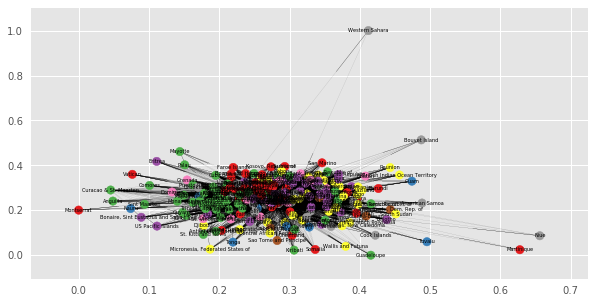

In [46]:
## decompose graph using Louvain algorithm
l_community = community.best_partition(ud_G,weight='weight',resolution=1)
layout = nx.spring_layout(G)
plt.figure(1, figsize=(10,5))
nx.draw_networkx(G,
                 pos=layout,
                 nodelist=list(l_community.keys()),
                 node_size = 70,  ## change the size of the node, based on degree
                 node_color=list(l_community.values()),                   ## change color abased on degree
                 width=0.05,
                 font_size=5,
                 cmap='Set1',                                 ## choose one color map http://matplotlib.org/users/colormaps.html
                 )

In [44]:
from collections import Counter
Counter(list(l_community.values()))

Counter({0: 51, 1: 9, 2: 54, 3: 37, 4: 34, 5: 6, 6: 16, 7: 27})

In [34]:
nx.write_gexf(G, str(year)+"_"+var+".gexf")